In [24]:
import numpy as np
from numpy import ndarray
from typing import Tuple
import json, sys, os, torch, torchvision
from torch.utils import data
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# input geometry array
input_path = '/Users/ethanherron/Desktop/ME 592/DM/data/Input_geometry'
for i in range(1,65):
    data_path = os.path.join(input_path, 'run'+str(i))
    for j in range(1,4):
        data = np.loadtxt(os.path.join(data_path, 'smesh.1.'+str(j)+'.txt'),skiprows=5,max_rows=204)
        temp = np.delete(data, 3, 1)
        reshaped_temp = np.resize(temp,(17,12))
        if j == 1:
            mesh_array = reshaped_temp
        else:
            mesh_array = np.dstack((mesh_array,reshaped_temp))
    temp_run_array = np.reshape(mesh_array,(1,17,12,3))
    if i == 1:
        run_array = temp_run_array
    else:
        run_array = np.concatenate((run_array,temp_run_array))
print(run_array.shape)

(64, 17, 12, 3)


In [4]:
# final geometry array -> (timestep, temperature, pressure, geometry)
#                         (    2   ,      5     ,     3   ,(17,12,3))

output_path = '/Users/ethanherron/Desktop/ME 592/DM/data/final_geometry'
for time_step in range(1,3):
    for temp in range(1,6): #find temp array
        for pressure in range(1,4): #find pressure array
            for mesh_number in range(1,65):
                try: # 80_t1_p2_49 is missing -> trying to use np.zeros to ~ignore~ the missing file
                    if time_step == 1:
                        per_mesh_path = os.path.join(output_path,'result_80_t'+str(temp)+'_p'+str(pressure)+'_'+str(mesh_number))
                        temp_data = np.loadtxt(per_mesh_path,skiprows=1)
                        per_mesh_array = np.resize(temp_data,(17,12,3))
                    else:
                        per_mesh_path = os.path.join(output_path,'result_140_t'+str(temp)+'_p'+str(pressure)+'_'+str(mesh_number))
                        temp_data = np.loadtxt(per_mesh_path,skiprows=1)
                        per_mesh_array = np.resize(temp_data,(17,12,3))
                except OSError: 
                    per_mesh_array = np.zeros((17,12,3))
                temp_per_mesh_array = np.expand_dims(per_mesh_array,axis=0)
                if mesh_number == 1:
                    mesh_array = temp_per_mesh_array
                else:
                    mesh_array = np.concatenate((mesh_array,temp_per_mesh_array))
            temp_pressure_array = np.expand_dims(mesh_array,axis=0)
            if pressure == 1:
                pressure_array = temp_pressure_array
            else:
                pressure_array = np.concatenate((pressure_array,temp_pressure_array))
        temp_temp_array = np.expand_dims(pressure_array, axis=0)
        if temp == 1:
            temp_array = temp_temp_array
        else:
            temp_array = np.concatenate((temp_array, temp_temp_array))
    temp_timestep_array = np.expand_dims(temp_array,axis=0)
    if time_step == 1:
        timestep_array = temp_timestep_array
    else:
        timestep_array = np.concatenate((timestep_array,temp_timestep_array))
print(timestep_array.shape)

(2, 5, 3, 64, 17, 12, 3)


In [5]:
def generate_dict(input_geometries: ndarray, output_geometries: ndarray, 
                           time_step: int):
    ''' Generate ordered pairs - time independent - for preprocessing/training '''
#     assert input_geometries.shape == output_geometries.shape[3:]
    data_dict = {}
    data_dict['inputs'] = []
    data_dict['temp'] = []
    data_dict['pressure'] = []
    data_dict['outputs'] = []
    for temp in range(5):
        for pressure in range(3):
            for geometry in range(64):
                data_dict['inputs'].append(input_geometries[geometry][:][:][:])
                data_dict['temp'].append(temp+1)
                data_dict['pressure'].append(pressure+1)
                data_dict['outputs'].append(output_geometries[time_step][temp][pressure][geometry][:][:][:])
    return data_dict

In [6]:
timestep_80 = generate_dict(input_geometries= run_array, output_geometries= timestep_array, time_step= 0)

In [7]:
timestep_140 = generate_dict(input_geometries= run_array, output_geometries= timestep_array, time_step= 1)

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(whiten=True)
tsne = TSNE(n_components=2)

In [18]:
# go back to ndarray of input geometries and normalize them via pca whitening
temp_input_geoms = np.reshape(run_array, (64,612))
whitened_input_geometries = pca.fit_transform(temp_input_geoms)

In [19]:
# ndarray of output geometries normalized via pca whitening
# timestep = 80
temp_ts_80 = np.reshape(timestep_array[0][:][:][:][:][:][:],(960,612))
whitened_ts80_output_geometries = pca.fit_transform(temp_ts_80)
# time step = 140
temp_ts_140 = np.reshape(timestep_array[1][:][:][:][:][:][:],(960,612))
whitened_ts140_output_geometries = pca.fit_transform(temp_ts_140)

In [33]:
whitened_output_ts80 = np.reshape(whitened_ts80_output_geometries,(5, 3, 64, 17, 12, 3))
print(whitened_output_ts80.shape)
whitened_output_ts140 = np.reshape(whitened_ts140_output_geometries,(5, 3, 64, 17, 12, 3))
print(whitened_output_ts80.shape)

(5, 3, 64, 17, 12, 3)
(5, 3, 64, 17, 12, 3)


In [34]:
#first tsne plot - geometry
#condense to geometry -> (5*3*64,17*12*3)
geometry_tsne = np.reshape(whitened_output_ts80,(5*3*64,17*12*3))
geometry_embedded = tsne.fit_transform(geometry_tsne)
#condense to pressure -> (5*3,64*17*12*3)
pressure_tsne = np.reshape(whitened_output_ts80,(5*3,64*17*12*3))
pressure_embedded = tsne.fit_transform(pressure_tsne)
#condense to temperature -> (5, 3*64*17*12*3)
temperature_tsne = np.reshape(whitened_output_ts80,(5, 3*64*17*12*3))
temperature_embedded = tsne.fit_transform(temperature_tsne)

In [35]:
#first tsne plot - geometry
#condense to geometry -> (5*3*64,17*12*3)
geometry_tsne_140 = np.reshape(whitened_output_ts140,(5*3*64,17*12*3))
geometry_embedded_140 = tsne.fit_transform(geometry_tsne_140)
#condense to pressure -> (5*3,64*17*12*3)
pressure_tsne_140 = np.reshape(whitened_output_ts140,(5*3,64*17*12*3))
pressure_embedded_140 = tsne.fit_transform(pressure_tsne_140)
#condense to temperature -> (5, 3*64*17*12*3)
temperature_tsne_140 = np.reshape(whitened_output_ts140,(5, 3*64*17*12*3))
temperature_embedded_140 = tsne.fit_transform(temperature_tsne_140)

/Users/ethanherron/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ethanherron/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


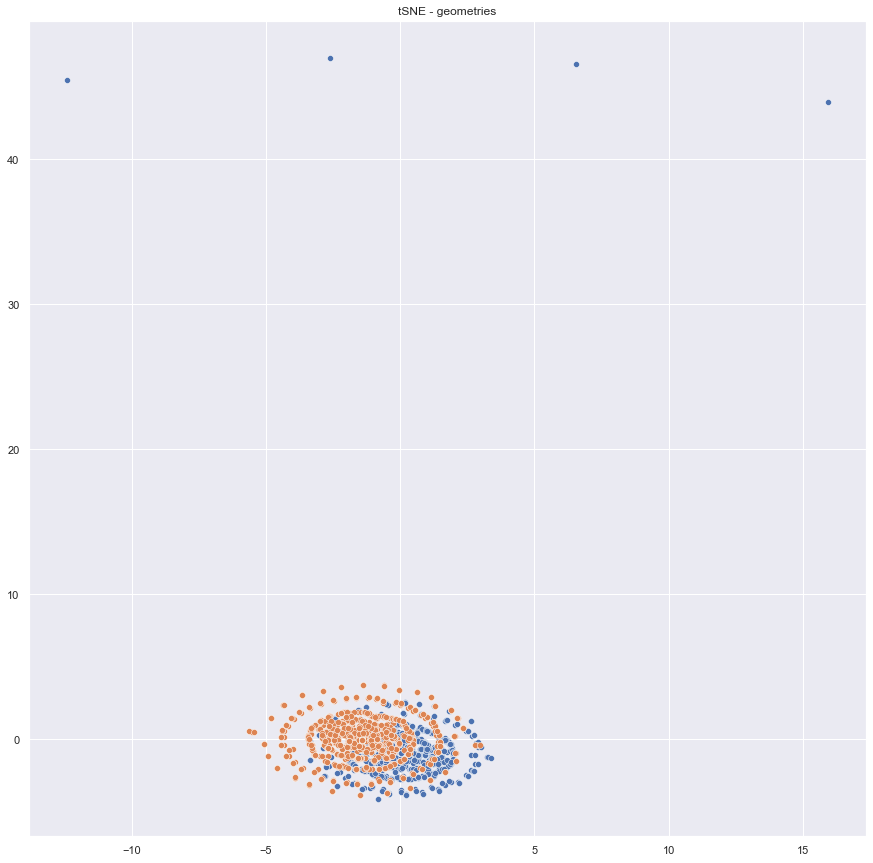

In [36]:
#init sns
sns.set(rc={'figure.figsize':(15,15)})
palette = sns.color_palette('bright',1)

#plot
sns.scatterplot(geometry_embedded[:,0],geometry_embedded[:,1], palette = palette)
sns.scatterplot(geometry_embedded_140[:,0],geometry_embedded_140[:,1], palette = palette)
plt.title('tSNE - geometries')
plt.show()

/Users/ethanherron/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ethanherron/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


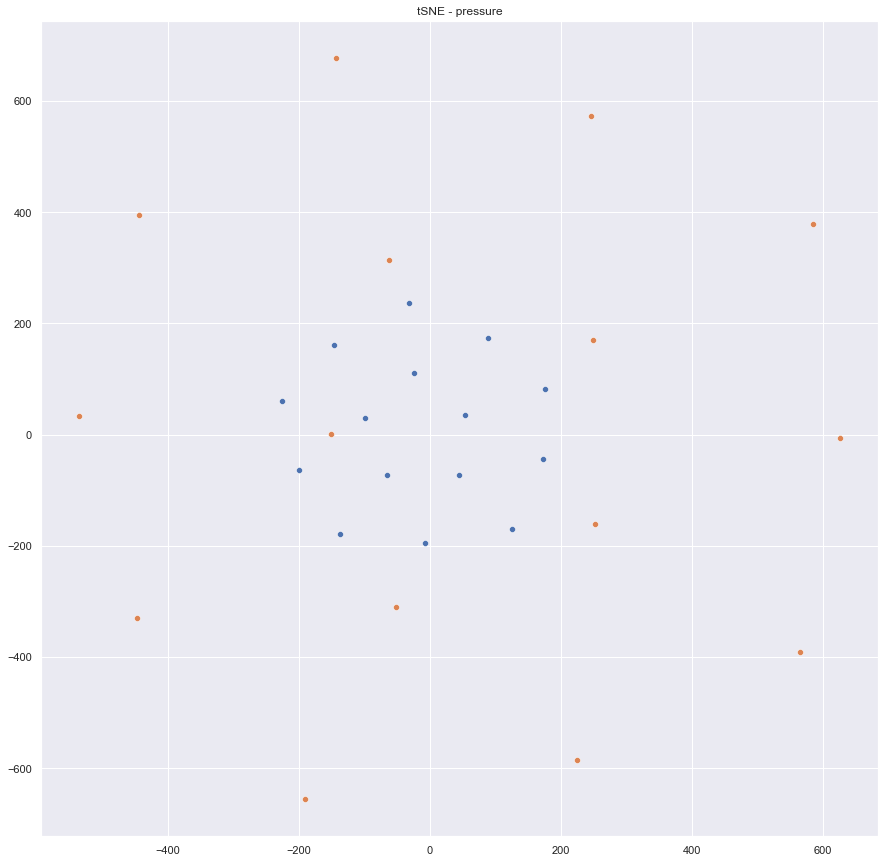

In [39]:
#init sns
sns.set(rc={'figure.figsize':(15,15)})
palette = sns.color_palette('bright',1)

#plot
sns.scatterplot(pressure_embedded[:,0],pressure_embedded[:,1], palette = palette)
sns.scatterplot(pressure_embedded_140[:,0],pressure_embedded_140[:,1], palette = palette)
plt.title('tSNE - pressure')
plt.show()

/Users/ethanherron/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ethanherron/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


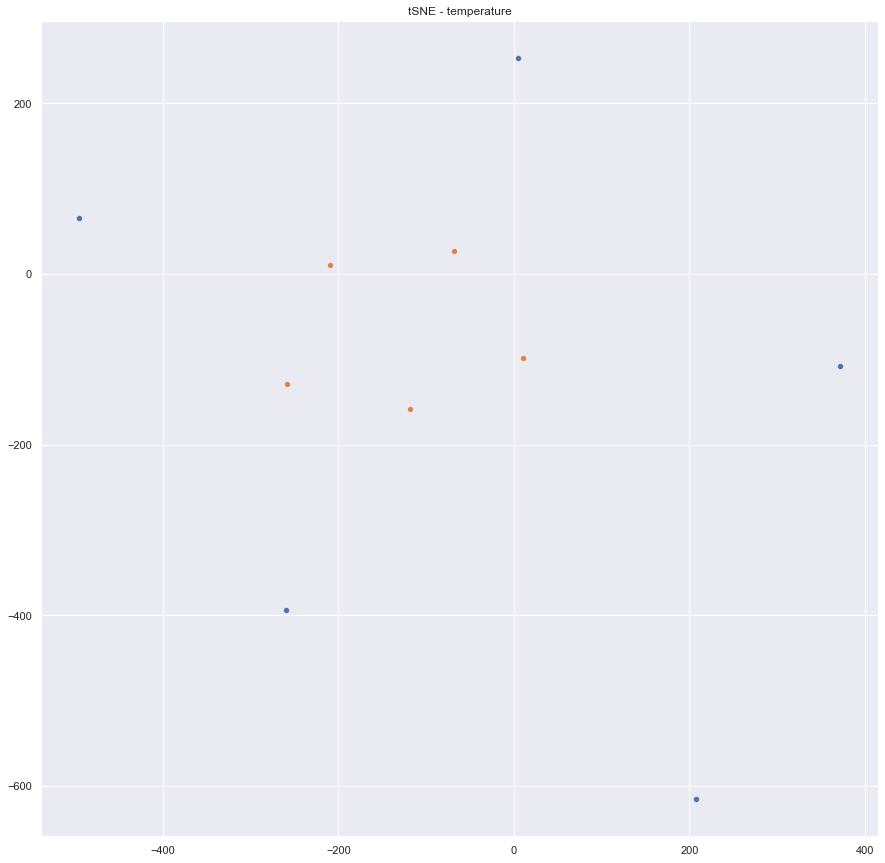

In [40]:
#init sns
sns.set(rc={'figure.figsize':(15,15)})
palette = sns.color_palette('bright',1)

#plot
sns.scatterplot(temperature_embedded[:,0],temperature_embedded[:,1], palette = palette)
sns.scatterplot(temperature_embedded_140[:,0],temperature_embedded_140[:,1], palette = palette)
plt.title('tSNE - temperature')
plt.show()